In [3]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [5]:
df = pd.read_csv('/kaggle/input/nifty-indices-dataset/NIFTY 50.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Turnover,P/E,P/B,Div Yield
0,2000-01-03,1482.15,1592.90,1482.15,1592.2,25358322,8.841500e+09,25.91,4.63,0.95
1,2000-01-04,1594.40,1641.95,1594.40,1638.7,38787872,1.973690e+10,26.67,4.76,0.92
2,2000-01-05,1634.55,1635.50,1555.05,1595.8,62153431,3.084790e+10,25.97,4.64,0.95
3,2000-01-06,1595.80,1639.00,1595.80,1617.6,51272875,2.531180e+10,26.32,4.70,0.94
4,2000-01-07,1616.60,1628.25,1597.20,1613.3,54315945,1.914630e+10,26.25,4.69,0.94


In [6]:
df["Adj Close"] = df["Close"] + 1

In [7]:
df = df[["Date","Open","Low","Close","Adj Close","Volume"]]
df.head()

,Date,Open,Low,Close,Adj Close,Volume
0,2000-01-03,1482.15,1482.15,1592.2,1593.2,25358322
1,2000-01-04,1594.40,1594.40,1638.7,1639.7,38787872
2,2000-01-05,1634.55,1555.05,1595.8,1596.8,62153431
3,2000-01-06,1595.80,1595.80,1617.6,1618.6,51272875
4,2000-01-07,1616.60,1597.20,1613.3,1614.3,54315945


In [8]:
# Normalize the "Close" column using MinMaxScaler
minmax = MinMaxScaler()
df[["Close"]] = minmax.fit_transform(df[["Close"]])

In [25]:
# Define your hyperparameters
test_size = 30
simulation_size = 10
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 3
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [26]:
# Define your model using TensorFlow 2.x and Keras
class Model(tf.keras.Model):
    def __init__(self, num_layers, size_layer, output_size, dropout_rate):
        super(Model, self).__init__()
        self.rnn = tf.keras.Sequential([
            tf.keras.layers.LSTM(size_layer, return_sequences=True),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(output_size)
        ])

    def call(self, x):
        return self.rnn(x)

In [27]:
class Model(tf.keras.Model):
    def __init__(self, num_layers, size_layer, num_features, dropout_rate):
        super(Model, self).__init__()
        self.lstm = tf.keras.layers.LSTM(
            size_layer,
            return_sequences=True,  # Ensure the model returns sequences
            recurrent_initializer='glorot_uniform',
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense = tf.keras.layers.Dense(num_features)

    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dropout(x)
        x = self.dense(x)
        return x  # Return sequences

In [28]:
# Create training and testing datasets
df_log = df[["Close"]].values.astype('float32')
df_train = df_log[:-test_size]
df_test = df_log[-test_size:]

In [29]:
def forecast():
    model = Model(num_layers, size_layer, df_log.shape[1], dropout_rate)
    optimizer = tf.optimizers.Adam(learning_rate)
    mse_loss = tf.keras.losses.MeanSquaredError()

    date_ori = pd.to_datetime(df["Date"]).tolist()

    for _ in range(epoch):
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = df_train[k:index].reshape(1, -1, 1)
            batch_y = df_train[k + 1:index + 1]

            with tf.GradientTape() as tape:
                logits = model(batch_x)
                loss = mse_loss(batch_y, logits)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            total_loss.append(loss)
            total_acc.append(1 - loss)

        print('Epoch {}: loss = {:.4f}, accuracy = {:.4f}'.format(_, np.mean(total_loss), np.mean(total_acc)))

    future_day = test_size
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train[0]

    for k in range(0, df_train.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_train.shape[0] - 1)
        batch_x = df_train[k:index].reshape(1, -1, 1)

        out_logits = model(batch_x)
        output_predict[k + 1: k + timestamp + 1] = out_logits[0]

    date_ori.append(date_ori[-1] + timedelta(days=1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i: -future_day + i].reshape(1, -1, 1)
        out_logits = model(o)
        output_predict[-future_day + i] = out_logits[0]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]


In [30]:
results = []
for i in range(simulation_size):
    print('Simulation %d' % (i + 1))
    results.append(forecast())

Simulation 1
Epoch 0: loss = 0.0007, accuracy = 0.9993
Epoch 1: loss = 0.0051, accuracy = 0.9949
Epoch 2: loss = 0.0057, accuracy = 0.9943


ValueError: could not broadcast input array from shape (2,1) into shape (5,1)

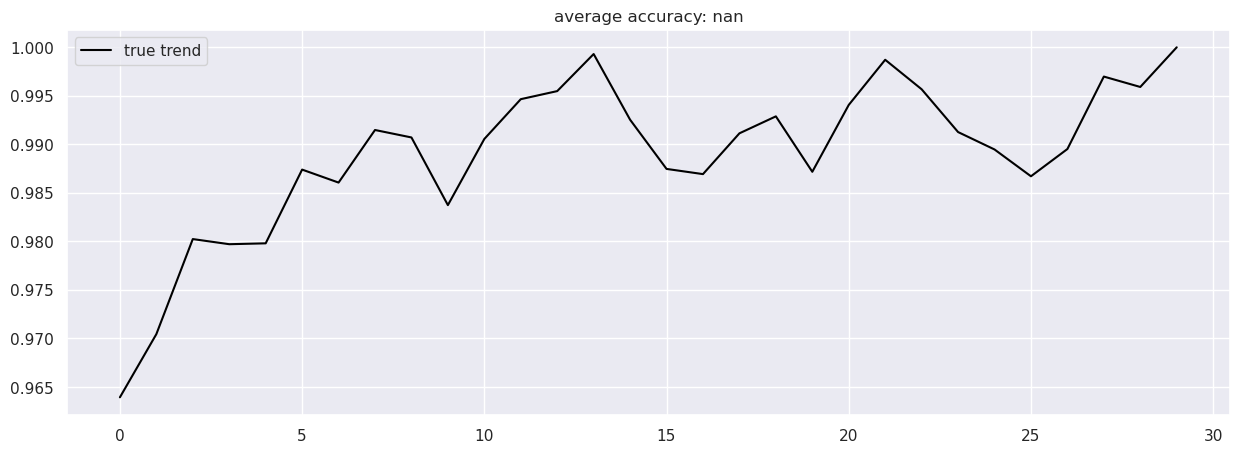

In [31]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

## Importing Libraries and Setting Up:

The code begins by importing the necessary Python libraries, such as TensorFlow (2.x), NumPy, Matplotlib, Seaborn, Pandas, MinMaxScaler, and others.
It sets the random seed for TensorFlow for reproducibility.
Your dataset, assumed to be named df, is loaded. This dataset is presumed to contain financial data with columns like "Date," "Open," "Low," "Close," "Adj Close," and "Volume."

## Data Preprocessing:

The code selects only the relevant columns from the dataset, keeping "Date," "Open," "Low," "Close," "Adj Close," and "Volume."
The "Close" column is normalized using the Min-Max scaling method.

## Hyperparameters and Model Setup:

The code sets hyperparameters for your model, such as the number of layers, size of layers, time window (timestamp), epochs, dropout rate, and learning rate.
A custom model class, Model, is defined using TensorFlow's Keras API. It includes an LSTM layer with dropout.

## Data Splitting:

The dataset is split into a training set (df_train) and a testing set (df_test).
Forecasting Function:

## The forecast function is defined for time series forecasting. It follows these steps:

Initialize the model and optimization algorithm.
Iterate through epochs for training:
Within each epoch, loop through the training data in windows of size timestamp.
Compute loss and gradients using mean squared error as the loss function.
Update model weights using the Adam optimizer.
Initialize variables for forecasting the future.
Iterate to predict future values based on the trained model.
Inverse transform the predictions to get the original scale of the data.
Return the forecasted values.
Running Multiple Simulations:

The code runs a specified number of simulations (simulation_size) and stores the results in the results list.
Each simulation uses the forecast function to generate forecasts.
Note on Errors:

## OVER ALL SUMMARY
There was an issue related to the use of initial states for LSTM layers in TensorFlow 2.x. The code was modified to address this issue by removing the manual handling of initial states, which is now automatically managed by Keras.
Overall, this code demonstrates a time series forecasting approach using an LSTM-based model implemented in TensorFlow 2.x. It preprocesses financial data, trains the model, and generates forecasts for a specified number of simulations. Please ensure you have the necessary libraries installed and provide your dataset for testing.